In [1]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [2]:
class LineWorld:
    def __init__(self, nb_cells=10, start_cell=1, good_end_cell=9, bad_end_cell=0):
        self.done = None
        self.current_state = start_cell  # État actuel
        self.end_good_state = good_end_cell  # État final
        self.end_bad_state = bad_end_cell
        self.reward = 0.0
        self.num_states = nb_cells  # Nombre total d'états
        self.states = [i for i in range(nb_cells)]
        self.actions = [0, 1]
        self.num_actions = 2  # Nombre total d'actions possibles
        self.line_world = ["_"] * (self.num_states - 1)
        self.line_world.insert(self.current_state, "X")

    def reset(self):
        self.reward = 0.0
        self.done = False
        self.current_state = np.random.randint(1, 8)

    def state_description(self):
        return np.array([self.current_state / (self.num_states - 1) * 2.0 - 1.0])

    def state_dim(self):
        return len(self.state_description())

    def step(self, action):
        # Si l'action est 1, on avance à droite
        if (action == 1) and (self.current_state != self.end_good_state) and (self.current_state != self.end_bad_state):
            self.current_state += 1
            self.reward = 0  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'action est 0, on avance à gauche
        elif (action == 0) and (self.current_state != self.end_good_state) and (
                self.current_state != self.end_bad_state):
            self.current_state -= 1
            self.reward = 0  # Pas de récompense pour avancer
            self.line_world.remove("X")
            self.line_world.insert(self.current_state, "X")
            print(self.line_world)
        # Si l'on atteint l'état final, la partie est terminée
        if self.current_state == self.end_good_state:
            self.reward = 1  # Récompense de 1 pour atteindre l'état final
            # print(self.line_world)
            self.done = True
        elif self.current_state == self.end_bad_state:
            self.reward = -1
            # print(self.line_world)
            self.done = True
        return self.current_state, self.reward, self.done

In [3]:
def build_compile_model(line):
    model = tf.keras.models.Sequential()
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(len(line.actions), activation='linear'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [9]:
def dqn(line, max_iter=1000, gamma=0.99, alpha=0.1, epsilon=0.1):
    q_network = build_compile_model(line)
    nb_steps = 0
    first_episode = True
    
    step = 0
    reward = 0
    reward_per_episode = []
    step_by_episode = []
    
    for iteration in range(max_iter):
        if line.done:
            reward_per_episode.append(line.reward)
            step_by_episode.append(step)
            line.reset()
            step = 0
            cumumated_reward = 0
            
        actions = line.actions
        current_state = line.current_state
        q_values = q_network.predict(np.array([current_state]))[0]
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            a= np.argmax(q_values)

        old_reward = line.reward
        new_state, reward, done = line.step(a)
        print(done)

        q_values[a] = reward + gamma * np.amax(q_network.predict(np.array([new_state]))[0])
        q_network.fit(np.array([current_state]), np.array([q_values]), verbose=0)
        current_state = new_state
            
        step += 1
        print(step)

    return reward_per_episode, step_by_episode

1/1 [==============================] - 0s 289ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
True
1/1 [==============================] - 0s 48ms/step
1
1/1 [==============================] - 0s 40ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 46ms/step
1
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 58ms/step
2
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
3
1/1 [==============================] - 0s 64ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
4
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
5
1/1 [=================

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 50ms/step
3
1/1 [==============================] - 0s 54ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 74ms/step
4
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
5
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 45ms/step
6
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 54ms/step
7
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 63ms/step
8
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', 'X', '_

1/1 [==============================] - 0s 56ms/step
3
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 37ms/step
1
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 42ms/step
2
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 50ms/step
3
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 36ms/step
4
1/1 [==============================] - 0s 58ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
5
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [=================

5
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 44ms/step
6
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 53ms/step
7
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 133ms/step
1
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 38ms/step
2
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 54ms/step
3
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 44ms/step
4
1/1 [===============

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 38ms/step
3
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 59ms/step
4
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 46ms/step
5
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 45ms/step
6
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
1
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_

1/1 [==============================] - 0s 54ms/step
6
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 63ms/step
7
1/1 [==============================] - 0s 59ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 56ms/step
8
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 46ms/step
9
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 49ms/step
10
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 53ms/step
1
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==================

1/1 [==============================] - 0s 59ms/step
6
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 44ms/step
7
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 45ms/step
8
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 48ms/step
9
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 39ms/step
1
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==================

4
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 41ms/step
5
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 42ms/step
6
1/1 [==============================] - 0s 43ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
2
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 52ms/step
3
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 45ms/step
4
1/1 [================

1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
3
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 44ms/step
4
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 42ms/step
5
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 51ms/step
1
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 42ms/step
2
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
3
1/1 [==================

['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 45ms/step
2
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 42ms/step
3
1/1 [==============================] - 0s 43ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
1
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
3
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_

1/1 [==============================] - 0s 47ms/step
8
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 52ms/step
9
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 44ms/step
1
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
1
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 46ms/step
2
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [===================

2
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
3
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 42ms/step
4
1/1 [==============================] - 0s 57ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 43ms/step
5
1/1 [==============================] - 0s 42ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
1
1/1 [==============================] - 0s 41ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 42ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
3
1/1 [================

['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 44ms/step
1
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 52ms/step
2
1/1 [==============================] - 0s 60ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 45ms/step
3
1/1 [==============================] - 0s 72ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 53ms/step
4
1/1 [==============================] - 0s 73ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 63ms/step
5
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 91ms/step
6
1/1 [==============================] - 0s 71ms/step
['_', '_', '_', '_', '

1/1 [==============================] - 0s 39ms/step
8
1/1 [==============================] - 0s 40ms/step
['X', '_', '_', '_', '_', '_', '_', '_', '_', '_']
True
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 38ms/step
2
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 42ms/step
3
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 40ms/step
4
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [===================

6
1/1 [==============================] - 0s 53ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
7
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
8
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
9
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 51ms/step
10
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 44ms/step
11
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 41ms/step
12
1/1 [=============

1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 47ms/step
6
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 46ms/step
7
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 52ms/step
8
1/1 [==============================] - 0s 47ms/step
['_', 'X', '_', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 49ms/step
1
1/1 [==============================] - 0s 47ms/step
['_', '_', 'X', '_', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 48ms/step
2
1/1 [==============================] - 0s 56ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
3
1/1 [==================

1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 42ms/step
3
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 40ms/step
4
1/1 [==============================] - 0s 53ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 76ms/step
5
1/1 [==============================] - 0s 50ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 44ms/step
6
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 49ms/step
7
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 45ms/step
8
1/1 [=================

['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
4
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 50ms/step
5
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 45ms/step
6
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', '_', '_', '_', 'X']
True
1/1 [==============================] - 0s 51ms/step
7
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 48ms/step
2
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_

1/1 [==============================] - 0s 54ms/step
1
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
2
1/1 [==============================] - 0s 65ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 48ms/step
3
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 45ms/step
4
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 41ms/step
5
1/1 [==============================] - 0s 55ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 45ms/step
6
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [=================

3
1/1 [==============================] - 0s 52ms/step
['_', '_', '_', 'X', '_', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 35ms/step
1
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', 'X', '_', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 48ms/step
2
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', 'X', '_', '_', '_', '_']
False
1/1 [==============================] - 0s 43ms/step
3
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_', 'X', '_', '_', '_']
False
1/1 [==============================] - 0s 46ms/step
4
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_', '_', 'X', '_', '_']
False
1/1 [==============================] - 0s 46ms/step
5
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_', '_', '_', 'X', '_']
False
1/1 [==============================] - 0s 40ms/step
6
1/1 [===============

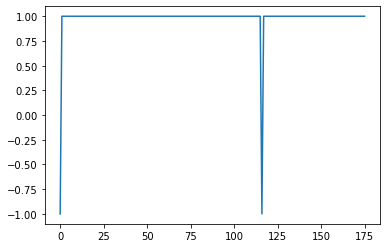

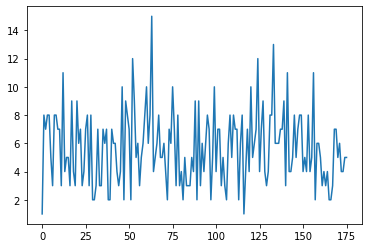

In [10]:
if __name__ == '__main__':
    world = LineWorld()
    #For 1000
    scores, steps = dqn(world, max_iter = 1000)
    plt.plot(scores)
    plt.show()
    plt.plot(steps)
    plt.show()
    #For 10000
    scores, steps = dqn(world, max_iter = 10000)
    plt.plot(scores)
    plt.show()
    plt.plot(steps)
    plt.show()